In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from os.path import exists

sys.path.append('../..')

In [3]:
import pylab as plt

from stable_baselines3 import PPO

In [4]:
from vimms.Common import POSITIVE, set_log_level_warning, load_obj, save_obj
from vimms.Chemicals import ChemicalMixtureFromMZML
from vimms.Roi import RoiBuilderParams

from vimms_gym.evaluation import run_method
from vimms_gym.common import METHOD_PPO, METHOD_TOPN, METHOD_RANDOM
from vimms_gym.visualisation import plot_N, plot_ms1_ms2_counts, plot_action_hist, plot_action_probs, plot_reward_probs

/opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/psims/mzmlb/writer.py:15: UserWarning: hdf5plugin is missing! Only the slower GZIP compression scheme will be available! Please install hdf5plugin to be able to use Blosc.
  warnings.warn(


# 1. Parameters

In [5]:
mz_range = (70, 1000)
rt_range = (0, 1440)

In [6]:
min_mz = mz_range[0]
max_mz = mz_range[1]
min_rt = rt_range[0]
max_rt = rt_range[1]

In [7]:
isolation_window = 0.7
N = 10
rt_tol = 120
small_rt_tol = 15
mz_tol = 10
min_ms1_intensity = 5000
ionisation_mode = POSITIVE

In [8]:
params = {
    'chemical_creator': None,
    'noise': {
        'enable_spike_noise': False,
    },
    'env': {
        'ionisation_mode': ionisation_mode,
        'rt_range': rt_range,
        'isolation_window': isolation_window,
        'mz_tol': mz_tol,
        'rt_tol': rt_tol,
    }
}

In [9]:
max_peaks = 200
in_dir = '../QCB_chems/results'

# 2. Evaluation on QCB data

In [10]:
env_name = 'DDAEnv'

In [11]:
eval_dir = 'evaluation_QCB'
methods = [
    METHOD_PPO,
    METHOD_TOPN,
    METHOD_RANDOM,    
]
out_dir = eval_dir
in_dir, out_dir

('../QCB_chems/results', 'evaluation_QCB')

In [12]:
intensity_threshold = 0.5

#### Load pre-processed QCB chemicals

In [13]:
fullscan_file = '../fullscan_QCB.mzML'

In [14]:
# min_roi_intensity = 0
# min_roi_length = 0

# min_roi_intensity = 500
# min_roi_length = 0
# at_least_one_point_above = 5000

min_roi_intensity = 0
min_roi_length = 3
at_least_one_point_above = 1000

In [15]:
filename = '../datasets_%d_%d_%d.p' % (min_roi_intensity, min_roi_length, at_least_one_point_above)

if exists(filename):
    chemicals = load_obj(filename)
    print(len(chemicals))
else:
    rp = RoiBuilderParams(min_roi_intensity=min_roi_intensity, min_roi_length=min_roi_length, 
                   at_least_one_point_above=at_least_one_point_above)
    cm = ChemicalMixtureFromMZML(fullscan_file, roi_params=rp)
    chemicals = cm.sample(None, 2, source_polarity=ionisation_mode)
    print(len(chemicals))
    save_obj(chemicals, filename)

43107


#### Filter chemicals by mz and RT range

In [16]:
filtered = []
for chem in chemicals:
    if (min_mz < chem.isotopes[0][0] < max_mz) and (min_rt < chem.rt < max_rt):
        filtered.append(chem)
        
len(filtered)

43060

In [17]:
filtered_chem_list = [filtered]

In [18]:
n_eval_episodes = 1
deterministic = True

In [19]:
set_log_level_warning()

1

In [20]:
chem_list = filtered_chem_list

## Run different methods

In [21]:
eval_dir = 'visualisation_QCB'

In [22]:
for chems in chem_list:
    print(len(chems))

43060


In [23]:
max_peaks

200

In [24]:
out_dir = eval_dir
in_dir, out_dir

('../QCB_chems/results', 'visualisation_QCB')

In [25]:
all_results = {}

In [26]:
env_name = 'DDAEnv'

### Run PPO

In [27]:
method = METHOD_PPO

In [28]:
model_name = 'PPO'

In [29]:
effective_rt_tol = rt_tol
copy_params = dict(params)        
copy_params['env']['rt_tol'] = effective_rt_tol
copy_params

{'chemical_creator': None,
 'noise': {'enable_spike_noise': False},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (0, 1440),
  'isolation_window': 0.7,
  'mz_tol': 10,
  'rt_tol': 120}}

In [30]:
fname = os.path.join(in_dir, '%s_%s.zip' % (env_name, model_name))
model = PPO.load(fname)

In [31]:
results = run_method(env_name, copy_params, max_peaks, chem_list, method, out_dir, model=model, print_eval=True, print_reward=True)


Episode 0 (43060 chemicals)
steps	 500 	total rewards	 53.11429185243036
steps	 1000 	total rewards	 159.18241639874827
steps	 1500 	total rewards	 268.71526246626473
steps	 2000 	total rewards	 398.55271020383356
steps	 2500 	total rewards	 533.8610785652661
steps	 3000 	total rewards	 642.9204085201513
steps	 3500 	total rewards	 697.9096263842875
steps	 4000 	total rewards	 739.8256643857824
steps	 4500 	total rewards	 776.6669276952528
steps	 5000 	total rewards	 808.6284816075087
Finished after 5216 timesteps with total reward 822.3447947969798
{'coverage_prop': '0.046', 'intensity_prop': '0.030', 'ms1/ms2 ratio': '0.613', 'efficiency': '0.606', 'TP': '866', 'FP': '257', 'FN': '41937', 'precision': '0.771', 'recall': '0.020', 'f1': '0.039'}


In [32]:
ppo_result = results[0]
ppo_result

### Run Top-N

In [33]:
method = METHOD_TOPN

In [34]:
effective_rt_tol = small_rt_tol
copy_params = dict(params)        
copy_params['env']['rt_tol'] = effective_rt_tol
copy_params

{'chemical_creator': None,
 'noise': {'enable_spike_noise': False},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (0, 1440),
  'isolation_window': 0.7,
  'mz_tol': 10,
  'rt_tol': 15}}

In [35]:
model = None

In [36]:
results = run_method(env_name, copy_params, max_peaks, chem_list, method, out_dir, N=10, model=model, print_eval=True, print_reward=True)


Episode 0 (43060 chemicals)
steps	 500 	total rewards	 27.30326929199802
steps	 1000 	total rewards	 138.6030665041288
steps	 1500 	total rewards	 295.64309089391526
steps	 2000 	total rewards	 437.9084496625554
steps	 2500 	total rewards	 600.8819697481357
steps	 3000 	total rewards	 770.8549484933408
steps	 3500 	total rewards	 882.2905320137443
steps	 4000 	total rewards	 944.9729494893121
steps	 4500 	total rewards	 993.5427735775055
steps	 5000 	total rewards	 1038.8382245956093
steps	 5500 	total rewards	 1064.3054633726329
steps	 6000 	total rewards	 1090.998318155938
Finished after 6273 timesteps with total reward 1099.9493897492334
{'coverage_prop': '0.074', 'intensity_prop': '0.049', 'ms1/ms2 ratio': '0.173', 'efficiency': '0.596', 'TP': '1357', 'FP': '494', 'FN': '41209', 'precision': '0.733', 'recall': '0.032', 'f1': '0.061'}


In [37]:
topN_result = results[0]
topN_result

# 3. Visualisation

## Visualise some results from the first episode

Limit some plots to the first 1000 steps.

In [38]:
limit = 1000

Plot the distribution of N: the number of MS2 scans that follow an MS1 scan

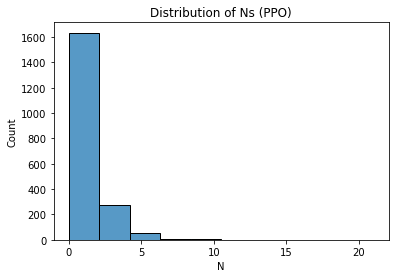

In [39]:
plot_N(ppo_result, bins=10, title='Distribution of Ns (PPO)')

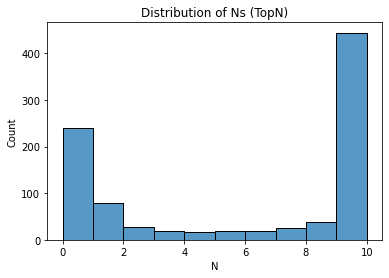

In [40]:
plot_N(topN_result, bins=10, title='Distribution of Ns (TopN)')

Plot the number of MS1 and MS2 scans over time

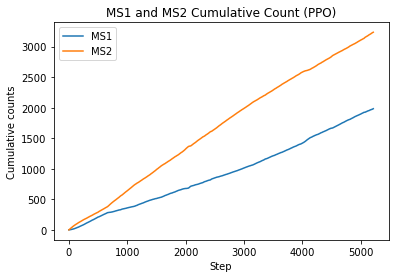

In [41]:
ppo_ms1, ppo_ms2 = plot_ms1_ms2_counts(ppo_result, title='MS1 and MS2 Cumulative Count (PPO)')

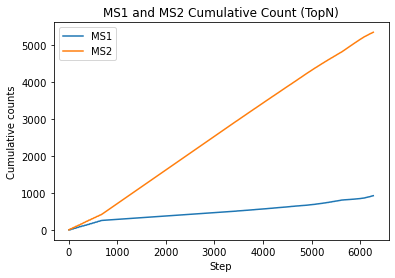

In [42]:
topN_ms1, topN_ms2 = plot_ms1_ms2_counts(topN_result, title='MS1 and MS2 Cumulative Count (TopN)')

Text(0.5, 1.0, 'MS2 Cumulative Counts')

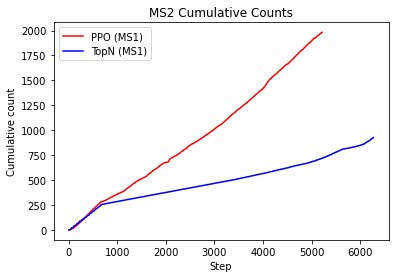

In [43]:
plt.plot(ppo_ms1, 'r-', label='PPO (MS1)')
plt.plot(topN_ms1, 'b-', label='TopN (MS1)')
plt.legend()
plt.ylabel('Cumulative count')
plt.xlabel('Step')
plt.title('MS2 Cumulative Counts')

Plot a histogram of all actions.

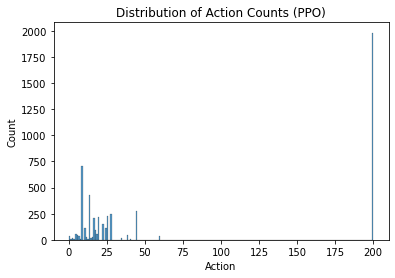

In [44]:
plot_action_hist(ppo_result, bins=200, title='Distribution of Action Counts (PPO)')

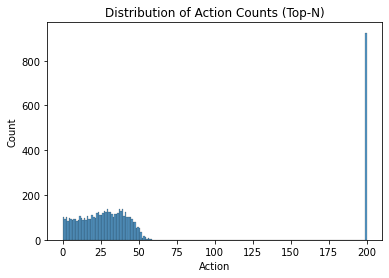

In [45]:
plot_action_hist(topN_result, bins=200, title='Distribution of Action Counts (Top-N)')

Plot a histogram of MS2-actions only

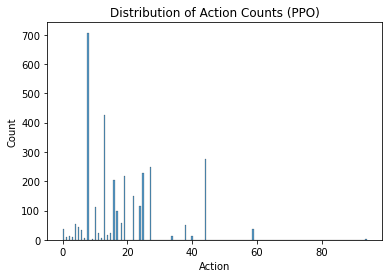

In [46]:
plot_action_hist(ppo_result, ms2_only=True, bins=199, title='Distribution of Action Counts (PPO)')

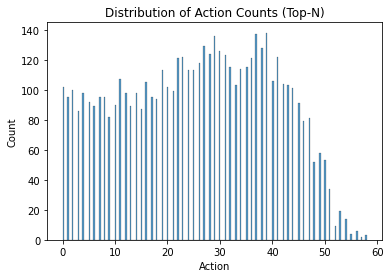

In [47]:
plot_action_hist(topN_result, ms2_only=True, bins=199, title='Distribution of Action Counts (Top-N)')

Show the first few actions

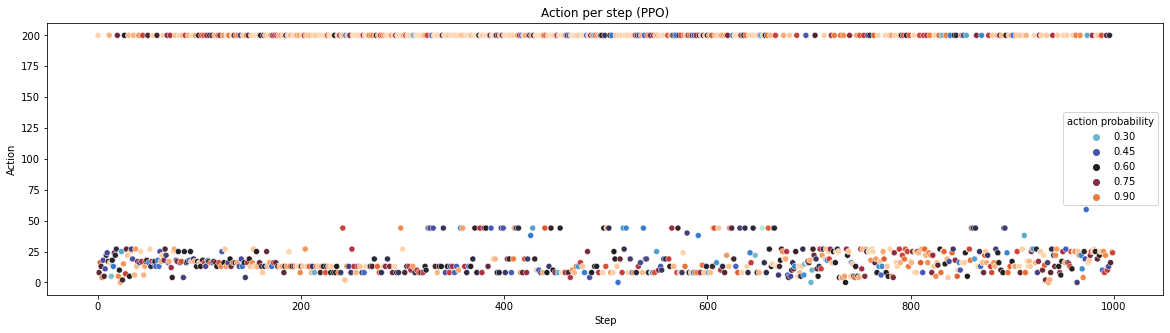

In [48]:
plot_action_probs(ppo_result, limit, max_peaks, title='Action per step (PPO)')

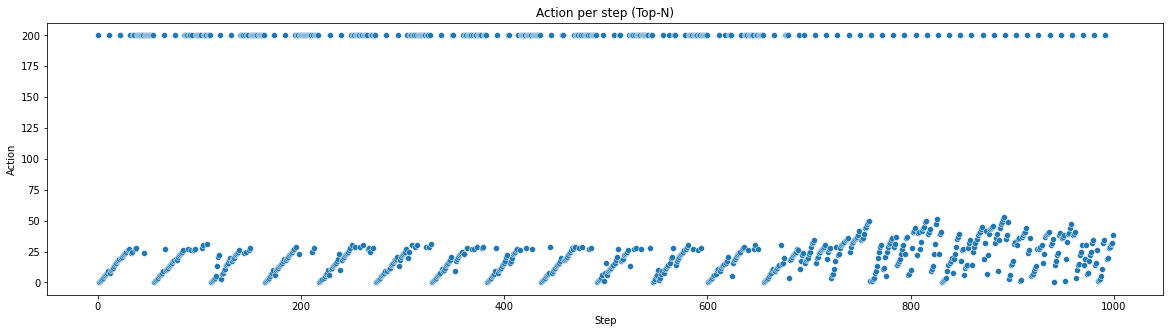

In [49]:
plot_action_probs(topN_result, limit, max_peaks, title='Action per step (Top-N)')

Plot rewards coloured by action probabilities

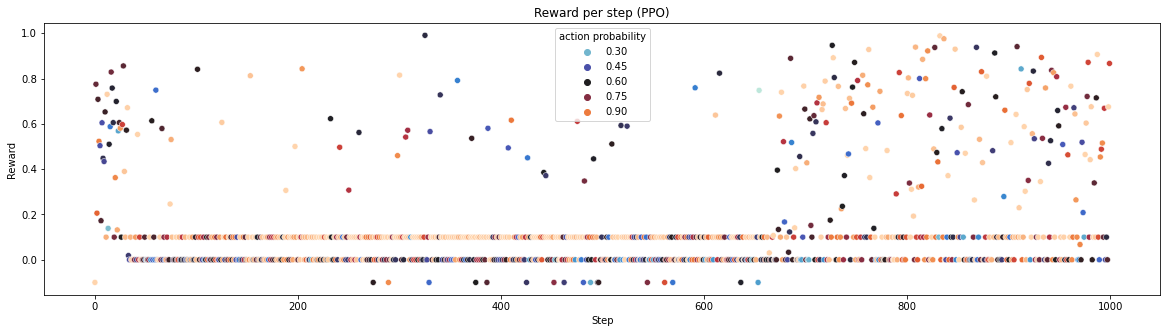

In [50]:
plot_reward_probs(ppo_result, limit, max_peaks, title='Reward per step (PPO)')

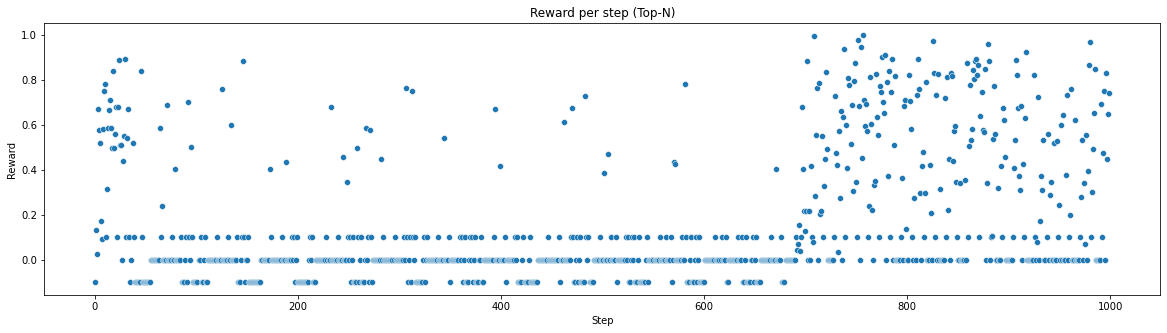

In [51]:
plot_reward_probs(topN_result, limit, max_peaks, title='Reward per step (Top-N)')